# Compare Approximated vs. Detailed Contact Maps

Evaluate the difference between approximated and detailed contact maps. Approximated contact maps assume that all beads in adjacent voxels form contacts. Detailed contact maps evaluate explicit pairwise distances between nucleosomes to establish contacts.

**Needs to be tested and potentially debugged**

### Import Modules

In [1]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Specify Simulation

See `get_approx_cmap.ipynb` and `get_detailed_cmap.ipynb` for demonstration of how to generate detailed and approximate contact maps, respectively.

In [2]:
output_dir = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output"
sim_ind = 33
cmap_detailed_file = "cmap_detailed.csv"
cmap_approx_file = "cmap_approx.csv"
max_scale = 5

### Load Contact Maps

In [3]:
cmap_detailed = np.log10(pd.read_csv(
    f"{output_dir}/sim_{sim_ind}/{cmap_detailed_file}", header=None
).to_numpy() + 1) 
cmap_approx = np.log10(pd.read_csv(
    f"{output_dir}/sim_{sim_ind}/{cmap_approx_file}", header=None
).to_numpy() + 1)

### Create a Common Scale of Contact Frequencies

In [4]:
cmap_detailed_plot = cmap_detailed.copy()
upper_percentile_signals = np.percentile(cmap_detailed_plot, 99)
cmap_detailed_plot *= max_scale / upper_percentile_signals

In [5]:
cmap_approx_plot = cmap_approx.copy()
upper_percentile_signals = np.percentile(cmap_approx_plot, 99)
cmap_approx_plot *= max_scale / upper_percentile_signals

### Resize the Higher-Resolution Contact Map

Contact maps may come in different resolutions. Just because a contact map is generated using "detailed" methods does not mean that it is a higher resolution than a contact map generated using "approximate" methods. Recall that the "detailed" and "approximate" labels refer to how contacts are defined -- whether based on voxel positions or pairwise distances -- not based on the resolution of the contact map.

In [6]:
if cmap_detailed_plot.shape[0] > cmap_approx_plot.shape[0]:
    cmap_detailed_plot_resized = skimage.transform.resize(
        cmap_detailed_plot,
        (
            cmap_approx_plot.shape[0],
            cmap_approx_plot.shape[1]
        ),
        anti_aliasing=True
    )
    cmap_approx_plot_resized = cmap_approx_plot.copy()
else:
    cmap_approx_plot_resized = skimage.transform.resize(
        cmap_approx_plot,
        (
            cmap_detailed_plot.shape[0],
            cmap_detailed_plot.shape[1]
        ),
        anti_aliasing=True
    )
    cmap_detailed_plot_resized = cmap_detailed_plot.copy()

### Calculate the Correlation Coefficient Between the Contact Maps

In [7]:
correlation = np.corrcoef(
    cmap_detailed_plot_resized.flat,
    cmap_approx_plot_resized.flat
)[0, 1]
print(f"Correlation Coefficient: {round(correlation, 3)}")

Correlation Coefficient: 0.747


### Plot the Detailed vs. Approximated Contact Maps

We scale the intensity of the two contact maps so that they have the same 99-percentile value, set to `max_scale`.

In [8]:
# Fixed reference for normalization
max_scale = 5
percentile = 99

# Approximate contact map on the top right
cmap_approx_upper = np.triu(cmap_approx_plot_resized)
cmap_approx_upper *= max_scale / (np.percentile(cmap_approx_upper, percentile))

# Erase the bottom left from the approximate contact map
cmap_approx_plot = cmap_approx_upper.copy()
for i in range(len(cmap_approx_plot)):
    for j in range(i):
        cmap_approx_plot[i, j] = np.nan

# Detailed contact map in the lower left
cmap_detailed_lower = np.tril(cmap_detailed_plot_resized)
cmap_detailed_lower *= max_scale / (np.percentile(cmap_detailed_lower, percentile))

# Erase the top right from the refined contact map
cmap_detailed_plot = cmap_detailed_lower.copy()
for i in range(len(cmap_detailed_plot)):
    for j in range(i):
        cmap_detailed_plot[j, i] = np.nan

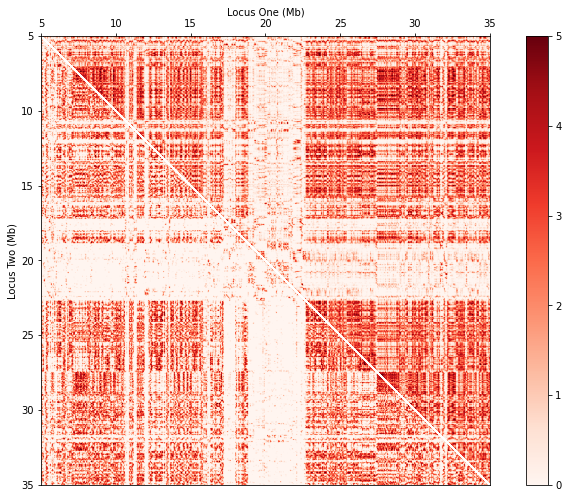

In [9]:
# Plot the contact maps
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
extents = [5, 35, 35, 5]
im = ax.imshow(cmap_approx_plot, cmap="Reds", extent=extents, vmin=0, vmax=max_scale)
im = ax.imshow(cmap_detailed_plot, cmap="Reds", extent=extents, vmin=0, vmax=max_scale)
ax.set_xticks([5, 10, 15, 20, 25, 30, 35])
ax.set_yticks([5, 10, 15, 20, 25, 30, 35])
ticks = np.arange(max_scale+1)
boundaries = np.linspace(0, max_scale, 1000)
ax.set_xlabel("Locus One (Mb)")
ax.set_ylabel("Locus Two (Mb)")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
fig.colorbar(im, cax=cax, orientation='vertical', ticks=ticks, boundaries=boundaries)
plt.tight_layout()
plt.show()